In [1]:
from ai2thor.controller import Controller
import ai2thor
print(ai2thor.__version__)
from ai2thor.platform import CloudRendering
from ai2thor.video_controller import VideoController
import cv2
import numpy as np
import math

5.0.0


In [2]:
def save_video(frames, filename='video.mp4', fps=20):
    import cv2
    size = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(filename, fourcc, fps, size)

    for i in range(len(frames)):
        frame = frames[i]
        image_with_text = frame.copy()
        out.write(frames[i])

    out.release()
    cv2.destroyAllWindows()

def save_gif(frames, filename='animation.gif', duration=0.1):
    from PIL import Image

    # Convert frames to PIL Image objects
    image_frames = [Image.fromarray(frame) for frame in frames]

    # Save frames as GIF
    image_frames[0].save(
        filename,
        save_all=True,
        append_images=image_frames[1:],
        optimize=False,
        duration=int(duration * 1000),
        loop=0
    )

def write_image(frame, agent_pos):
    image_with_text = np.array(frame, copy=True)
    image_with_text = cv2.cvtColor(image_with_text, cv2.COLOR_BGR2RGB)
    text_position = (image_with_text.shape[1] - 250, image_with_text.shape[0] - 20)
    text_content = f"Agent Position: ({agent_pos['x']}, {round(agent_pos['y'], 2)}, {round(agent_pos['z'],2)})"
    font_scale = 0.4
    font_thickness = max(1, int(font_scale * 1.5))
    cv2.putText(image_with_text, text_content, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,0,0), font_thickness, cv2.LINE_AA)
    return image_with_text

def get_obj(controller, asset_id):
    return [obj for obj in controller.last_event.metadata['objects'] if obj['assetId']==asset_id][0]

def calculate_distance(pos1, pos2):
    x1, y1, z1 = pos1['x'], pos1['y'], pos1['z']
    x2, y2, z2 = pos2['x'], pos2['y'], pos2['z']
    return np.linalg.norm(np.array([x1, y1, z1]) - np.array([x2, y2, z2]))

def calculate_angle(point1, point2):
    dx = point2['x'] - point1['x']
    dz = point2['z'] - point1['z']
    return math.degrees(math.atan2(dz, dx))

def calculate_distance(point1, point2):
    dx = point2['x'] - point1['x']
    dz = point2['z'] - point1['z']
    return math.sqrt(dx*dx + dz*dz)


In [ ]:
controller = Controller(platform=CloudRendering, scene='FloorPlan1')
frames = []
positions = controller.step(
    action="GetReachablePositions"
).metadata["actionReturn"]
frames.append(controller.last_event.frame)

bottle_instance = get_obj(controller, 'Bottle_1')

fridge_instance = get_obj(controller, 'Fridge_1')
obj_id = fridge_instance[0]['objectId']



event = controller.step(dict(action='OpenObject', objectId=obj_id))
frames.append(event.frame)
obj_in_fridge = [obj for obj in controller.last_event.metadata["objects"] if obj['parentReceptacles'] == [obj_id]]
event = controller.step(dict(action='PickupObject', objectId=obj_in_fridge[0]['objectId']))
frames.append(event.frame)
event = controller.step(dict(action='CloseObject', objectId=obj_id))
frames.append(event.frame)


for _ in range(90//5):
    frames.append(controller.step(action="RotateLeft", degrees=5).frame)

for _ in range(10):
    event = controller.step(action="MoveAhead")
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

for _ in range(7):
    event = controller.step(dict(action='MoveLeft'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

pan = [obj for obj in controller.last_event.metadata['objects'] if 'Pan' in obj['objectId']][0]
event = controller.step(dict(action='PutObject', objectId=pan['objectId']))
# print(event)
frames.append(event.frame)

event = controller.step(action="SliceObject", objectId=obj_in_fridge[0]['objectId'])
frames.append(event.frame)
event = controller.step(dict(action='PickupObject', objectId=pan['objectId']))
frames.append(event.frame)

for _ in range(4):
    event = controller.step(dict(action='MoveRight'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))


stove_burners = [obj for obj in event.metadata['objects'] if 'StoveBurner' in obj['objectId']]
stove_knobs = [obj for obj in event.metadata['objects'] if 'StoveKnob' in obj['objectId']]

event = controller.step(dict(action='PutObject', objectId=stove_burners[0]['objectId']))
frames.append(event.frame)

for _ in range(3):
    event = controller.step(action="MoveAhead")
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))


event = controller.step(dict(action='ToggleObjectOn', objectId=stove_knobs[2]['objectId']))
frames.append(event.frame)
event = controller.step(dict(action='LookDown'))
frames.append(event.frame)

event = controller.step(dict(action='ToggleObjectOn', objectId=stove_knobs[2]['objectId']))
frames.append(event.frame)


# save_video(frames, filename='video.mp4', fps=1)
save_gif(frames, 'animation.gif')

In [ ]:
controller = Controller(platform=CloudRendering, renderInstanceSegmentation=True, scene='FloorPlan1', width=720, height=720, fieldOfView=90)
event = controller.step(
    action="GetReachablePositions"
)

positions = event.metadata["actionReturn"]
# event = controller.step(
#     action='SetObjectStates', 
#     SetObjectStates={
#             'objectType': 'Bottle',
#             'stateChange': 'canFillWithLiquid', 
#             'isFilledWithLiquid': True,
#         }
# )
# print('Success =', event.metadata['lastActionSuccess'], ', error =', event.metadata['errorMessage'])
frames = []
frames.append(event.frame) # Get Reachable Positions

bottle_instance = get_obj(controller, 'Bottle_1')
fridge_instance = get_obj(controller, 'Fridge_1')

event = controller.step(
    action="PickupObject",
    objectId=bottle_instance['objectId'],
    forceAction=True
)
print('Success =', event.metadata['lastActionSuccess'], ', error =', event.metadata['errorMessage'])
frames.append(event.frame) # Pickup

bottle_instance = get_obj(controller, 'Bottle_1')
event = controller.step(action="FillObjectWithLiquid",
        objectId=bottle_instance['objectId'],
        fillLiquid='wine'
)
print('Success =', event.metadata['lastActionSuccess'], ', error =', event.metadata['errorMessage'])
frames.append(controller.last_event.frame) # Fill with wine

event = controller.step(
    action="OpenObject",
    objectId=fridge_instance['objectId'],
    forceAction=True
)
frames.append(controller.last_event.frame) # Open fridge

event = controller.step(
    action="PutObject",
    objectId=fridge_instance['objectId'],
    forceAction=True
)
print('Success =', event.metadata['lastActionSuccess'], ', error =', event.metadata['errorMessage'])
frames.append(controller.last_event.frame) # Put in fridge

frames.append(controller.step(action="LookDown").frame) # Look Down

event = controller.step(
    action="CloseObject",
    objectId=fridge_instance['objectId'],
    forceAction=True
)
frames.append(controller.last_event.frame) # Close fridge

pan_position = get_obj(controller, 'Pan_22')['position']
# Get close to pan
closest_pos = min(positions, key=lambda pos: calculate_distance(pos, pan_position))

event = controller.step(
    action="Teleport",
    position=closest_pos,
    standing=True
)

frames.append(event.frame) # Teleport to pan
controller.step(
    action="RotateLeft",
    degrees=90
)
frames.append(controller.last_event.frame) # Rotate
save_gif(frames, 'initial.gif')

In [ ]:
frames = []
for _ in range(90//5):
    frames.append(controller.step(action="RotateRight", degrees=5).frame)

for _ in range(10):
    event = controller.step(action="MoveAhead")
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

for _ in range(90//5):
    frames.append(controller.step(action="RotateRight", degrees=5).frame)

for _ in range(12):
    event = controller.step(action="MoveAhead")
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

event = controller.step(
    action="OpenObject",
    objectId=get_obj(controller, 'Fridge_1')['objectId'],
)
frames.append(controller.last_event.frame)
print(event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
for _ in range(90//10):
    frames.append(controller.step(action="RotateLeft", degrees=10).frame)

###############################################
obj_id = get_obj(controller, 'Fridge_1')['objectId']
obj_in_fridge = [obj for obj in controller.last_event.metadata["objects"] if obj['parentReceptacles'] == [obj_id]]
event = controller.step(dict(action='PickupObject', objectId=obj_in_fridge[-1]['objectId']))
frames.append(event.frame)
print(event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
event = controller.step(dict(action='CloseObject', objectId=obj_id))
frames.append(event.frame)


for _ in range(90//10):
    frames.append(controller.step(action="RotateLeft", degrees=10).frame)

for _ in range(12):
    event = controller.step(action="MoveAhead")
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

for _ in range(7):
    event = controller.step(dict(action='MoveLeft'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

pan = [obj for obj in controller.last_event.metadata['objects'] if 'Pan' in obj['objectId']][0]
event = controller.step(dict(action='PutObject', objectId=pan['objectId']))
# print(event)
frames.append(event.frame)

event = controller.step(action="SliceObject", objectId=obj_in_fridge[-1]['objectId'])
frames.append(event.frame)
print(event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
event = controller.step(dict(action='PickupObject', objectId=pan['objectId']))
frames.append(event.frame)

for _ in range(3):
    event = controller.step(dict(action='MoveRight'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

stove_burners = [obj for obj in event.metadata['objects'] if 'StoveBurner' in obj['objectId']]
stove_knobs = [obj for obj in event.metadata['objects'] if 'StoveKnob' in obj['objectId']]
stove_burner_pos = [obj['position'] for obj in stove_burners]
agent_pos = event.metadata['agent']['position']
closest_pos = min(stove_burner_pos, key=lambda pos: calculate_distance(pos, agent_pos))
closest_burner = [obj for obj in stove_burners if obj['position'] == closest_pos][0]
closest_knob = [obj for obj in stove_knobs if obj['controlledObjects'] == [closest_burner['objectId']]][0]

event = controller.step(dict(action='PutObject', objectId=closest_burner['objectId']))
frames.append(event.frame)
print(closest_burner['position'], '\n', event.metadata['agent']['position'])
print(event.metadata['lastActionSuccess'], event.metadata['errorMessage'])

event = controller.step(dict(action='ToggleObjectOn', objectId=closest_knob['objectId']))
frames.append(event.frame)

event = controller.step(dict(action='MoveLeft'))
frames.append(write_image(event.cv2img, event.metadata['agent']['position']))
# for _ in range(5):
#     event = controller.step(action="MoveAhead", moveMagnitude=0.2)
#     print(event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
#     frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

egg = get_obj(controller, 'Egg_1')
print(egg['position'], '\n', event.metadata['agent']['position'])
obj_id = egg['objectId']
event = controller.step(dict(action='PickupObject', objectId=obj_id))
print('pickup egg', event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
frames.append(event.frame)

event = controller.step(action="LookDown")
frames.append(event.frame)

egg = get_obj(controller, 'Egg_1')
print(egg['position'], '\n', event.metadata['agent']['position'])
obj_id = egg['objectId']
event = controller.step(dict(action='PickupObject', objectId=obj_id, forceAction=True))
print('pickup egg', event.metadata['lastActionSuccess'], event.metadata['errorMessage'])
frames.append(event.frame)

event = controller.step(action="LookUp")
frames.append(event.frame)

for _ in range(4):
    event = controller.step(dict(action='MoveLeft'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

for _ in range(180//20):
    frames.append(controller.step(action="RotateLeft", degrees=20).frame)

for _ in range(5):
    event = controller.step(dict(action='MoveAhead'))
    frames.append(write_image(event.cv2img, event.metadata['agent']['position']))

for _ in range(90//10):
    frames.append(controller.step(action="RotateLeft", degrees=10).frame)

for o in event.metadata['objects']:
    if o['visible']:
        print(o['objectId'], o['visible'], o['receptacle'], o['parentReceptacles'])

event = controller.step(dict(action='PutObject', objectId='Bowl|+00.27|+01.10|-00.75'))
frames.append(event.frame)

save_gif(frames, 'bottle.gif')


In [75]:
controller = Controller(platform=CloudRendering, renderInstanceSegmentation=True, scene='FloorPlan1', width=720, height=720, fieldOfView=90)
event = controller.step(
    action="GetReachablePositions"
)
positions = event.metadata["actionReturn"]
positions_tuple = [(p["x"], p["y"], p["z"]) for p in positions]


from ai2thor.util.metrics import (
    get_shortest_path_to_object_type
)

path = get_shortest_path_to_object_type(
   controller=controller,
    object_type="Pan",
    initial_position=event.metadata['agent']['position']
)
controller.frames = [event.frame]

In [76]:
from utils import shortest_path, get_neighbors
neighbors = get_neighbors(positions_tuple)
# {k: len(v) for k, v in neighbors.items()}

(-1.0, 0.900999128818512, 1.0) (-0.25, 0.900999128818512, -1.25)


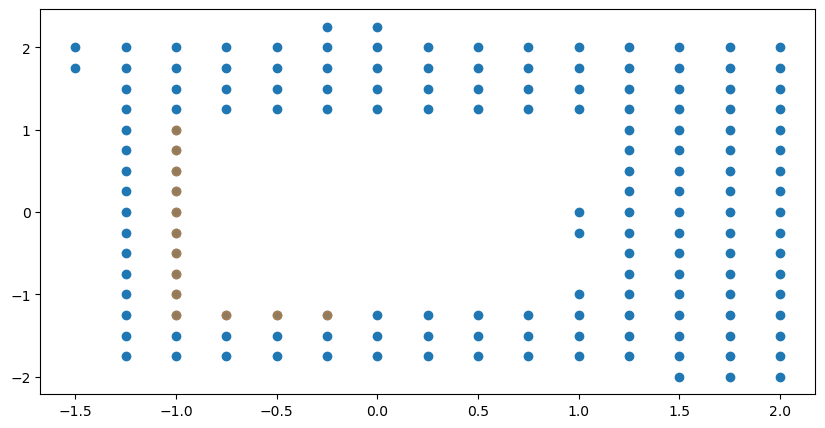

In [77]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
xs = [p[0] for p in positions_tuple]
zs = [p[2] for p in positions_tuple]
ax.scatter(xs, zs)
start = event.metadata['agent']['position']
start = list(start.values())
end = path[-1]
end = list(end.values())

path = shortest_path(start, end, neighbors, positions_tuple)
xs = [p[0] for p in path]
zs = [p[2] for p in path]
ax.scatter(xs, zs, alpha=0.5)

In [78]:
initial_position = controller.last_event.metadata['agent']['position']
initial_rotation = controller.last_event.metadata['agent']['rotation']
new_path = []
for p in path:
    new_path.append({'x': p[0], 'y': p[1], 'z': p[2]})
for i in range(len(new_path)):
    print('Initial Position', initial_position)
    print('Target Position', new_path[i])
    print('Initial Rotation', initial_rotation)
    target_point = new_path[i]

    dx = target_point['x'] - initial_position['x']
    dz = target_point['z'] - initial_position['z']

    current_yaw = initial_rotation['y']
    if dz == 0:
        if dx > 0:
            target_yaw = -90
        else:
            target_yaw = 90
    else:
        target_yaw = math.degrees(math.atan(dx/dz))
        
    diff = target_yaw - current_yaw

    rotation_angle = diff
    distance = math.sqrt((dx) ** 2 + (dz) ** 2)

    if distance == 0:
        print('continue','\n')
        continue
    print('Target Rotation', target_yaw)
    print('Rotate', rotation_angle)
    if rotation_angle not in [0, 180, -180]:
        event = controller.step(dict(action='RotateLeft', degrees=rotation_angle))
        controller.frames.append(event.frame)
        print('Success in rotation, new_rotation', controller.last_event.metadata['agent']['rotation'])
    initial_rotation = controller.last_event.metadata['agent']['rotation']
    # Move the agent forward
    print('Move ahead', distance)
    event = controller.step(dict(action='MoveAhead', moveMagnitude=distance))
    if event.metadata['lastActionSuccess']:
        controller.frames.append(event.frame)
        print('Success', '\n')
    else:
        print('Failed to move agent ', event.metadata['errorMessage'])
        # break

    initial_position = controller.last_event.metadata['agent']['position']
    if initial_position != target_point:
        print("Failed to reach target point")
        print('Move Position', initial_position)
        print('Target Position', target_point)

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}
Initial Rotation {'x': -0.0, 'y': 270.0, 'z': 0.0}
continue 

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 1.0}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.75}
Initial Rotation {'x': -0.0, 'y': 270.0, 'z': 0.0}
Target Rotation -0.0
Rotate -270.0


Success in rotation, new_rotation {'x': 0.0, 'y': 180.0, 'z': 0.0}
Move ahead 0.25
Success 

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.75}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.5}
Initial Rotation {'x': 0.0, 'y': 180.0, 'z': 0.0}
Target Rotation -0.0
Rotate -180.0
Move ahead 0.25
Success 

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.5}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.25}
Initial Rotation {'x': 0.0, 'y': 180.0, 'z': 0.0}
Target Rotation -0.0
Rotate -180.0
Move ahead 0.25
Success 

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.25}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.0}
Initial Rotation {'x': 0.0, 'y': 180.0, 'z': 0.0}
Target Rotation -0.0
Rotate -180.0
Move ahead 0.25
Success 

Initial Position {'x': -1.0, 'y': 0.900999128818512, 'z': 0.0}
Target Position {'x': -1.0, 'y': 0.900999128818512, 'z': -0.25}
Initial Rotation {'x': 0.0, 'y': 180.0, 'z': 0.0}
Target Rotation -0.

In [79]:
save_gif(controller.frames, 'path.gif')